In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
from scipy.spatial.distance import euclidean as eu
from scipy.spatial.distance import cosine 
import math
from scipy import signal

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import preprocessing

In [3]:
D_path = glob.glob('Data\Dyslexic' + "\*")
C_path = glob.glob('Data\Control' + "\*")

C_data = []
for path in C_path:
    temp = pd.read_csv(path)
    temp = temp.drop('Unnamed: 0',axis = 1)
    C_data.append(temp)

D_data = []
for path in D_path:
    temp = pd.read_csv(path)
    temp = temp.drop('Unnamed: 0',axis = 1)
    D_data.append(temp)
    
C_new = []
for data in C_data:
    X =data[['LX','RX']]
    Y =data[['LY','RY']]
    Xm = X.mean(axis=1)
    Ym = Y.mean(axis=1)
    f = pd.DataFrame([data.iloc[:,0],Xm,Ym])
    f = f.transpose()
    f = f.rename(columns = {'Unnamed 0': 'X', 'Unnamed 1': 'Y'})
    C_new.append(f)

D_new = []
for data in D_data:
    X =data[['LX','RX']]
    Y =data[['LY','RY']]
    Xm = X.mean(axis=1)
    Ym = Y.mean(axis=1)
    f = pd.DataFrame([data.iloc[:,0],Xm,Ym])
    f = f.transpose()
    f = f.rename(columns = {'Unnamed 0': 'X', 'Unnamed 1': 'Y'})
    D_new.append(f)

In [4]:


for i in range(len(C_new)):
    C_tempx = np.abs(C_new[i]['X'])
    mx = max(C_tempx)
    C_tempy = np.abs(C_new[i]['Y'])
    my= max(C_tempy)
    C_new[i]['X'] = C_new[i]['X']/np.abs(mx)
    C_new[i]['Y'] = C_new[i]['Y']/np.abs(my)
for i in range(len(D_new)):
    D_tempx = np.abs(D_new[i]['X'])
    mx = max(D_tempx)
    D_tempy = np.abs(D_new[i]['Y'])
    my= max(D_tempy)
    D_new[i]['X'] = D_new[i]['X']/np.abs(mx)
    D_new[i]['Y'] = D_new[i]['Y']/np.abs(my)    

In [5]:
C_cmx = []
C_real= []
C_img=[]
for j in range(len(C_new)):
    dat = C_new[j]
    x = dat['X']
    y = dat['Y']
    t = dat['T']
    
    z=[]
    x_in=[]
    y_in=[]
    for i in range(0,x.size):
        z.append(complex(x[i],y[i]))
        x_in.append(x[i])
        y_in.append(y[i])
    
    
    C_cmx.append(z)
    C_real.append(x_in)
    C_img.append(y_in)

D_cmx = []
D_real= []
D_img=[]
for j in range(len(D_new)):
    dat = D_new[j]
    x = dat['X']
    y = dat['Y']
    t = dat['T']
    
    z=[]
    x_in=[]
    y_in=[]
    for i in range(0,x.size):
        z.append(complex(x[i],y[i]))
        x_in.append(x[i])
        y_in.append(y[i])
    D_cmx.append(z)
    D_real.append(x_in)
    D_img.append(y_in)

In [6]:
#Stamdard STFT Run. Returns Full Flattened Vector
def stft_run(n_ratio,o_ratio):
    C_spec = []
    vec= []
    for j in range(len(tmat)):
        data = tmat[j]
        L= len(data)+1
        k = int((len(data) + 1)/250) # k varies from 4 to 8
        N=20
        B  = L/n_ratio
        E =B/o_ratio#round((N*B - L)/(N-1))
        nf = 2000/n_ratio
        f, t, Zxx = signal.stft(tmat[j],fs= L/250, nperseg=B,noverlap= E,nfft=nf)
        
        tot = np.abs(Zxx)**2
        
        
        C_spec.append(np.abs(Zxx)**2)
    
    vec = []
    for i in range(len(C_spec)):
        vec.append(C_spec[i])
    print(C_spec[i].shape)
    
    for i in range(len(C_spec)):
        vec[i]=vec[i].flatten()
    
    

    return vec

In [7]:
#Considers Bins till 'lim'. Returns flattened vector for only some bins
def stft_run_half(n_ratio,o_ratio,lim1,lim2):
    lim1= int(lim1)
    lim2= int(lim2)
    C_spec = []
    vec= []
    for j in range(len(tmat)):
        data = tmat[j]
        L= len(data)+1
        k = int((len(data) + 1)/250) # k varies from 4 to 8
        N=20
        B  = L/n_ratio
        E =B/o_ratio#round((N*B - L)/(N-1))
        nf = 2000/n_ratio
        f, t, Zxx = signal.stft(tmat[j],fs= L/250, nperseg=B,noverlap= E,nfft=nf)
        
        tot = np.abs(Zxx)**2
        half_im=[]
        for i in range(len(tot)):
            half_im.append(tot[i][lim1:lim2])
            #print(len(tot[i]))
        
        C_spec.append(np.asarray(half_im))
    
    vec = []
    for i in range(len(C_spec)):
        vec.append(C_spec[i])
    #print(C_spec[i].shape)
    
    for i in range(len(C_spec)):
        vec[i]=vec[i].flatten()
    
    

    return vec

In [8]:
#Flattened vector depending on frequency
def stft_run_freq(n_ratio,o_ratio,lim):
    lim= int(lim)
    #lim2= int(lim2)
    C_spec = []
    vec= []
    for j in range(len(tmat)):
        data = tmat[j]
        L= len(data)+1
        k = int((len(data) + 1)/250) # k varies from 4 to 8
        N=20
        B  = L/n_ratio
        E =B/o_ratio#round((N*B - L)/(N-1))
        nf = 2000/n_ratio
        f, t, Zxx = signal.stft(tmat[j],fs= L/250, nperseg=B,noverlap= E,nfft=nf)
        
        tot = np.abs(Zxx)**2
        
        
        C_spec.append(np.abs(Zxx)**2)
    
    vec = []
    for i in range(len(C_spec)):
        vec.append(C_spec[i])
    print(C_spec[i].shape)
    #print(len(vec[i][lim1:lim2]))
    lfvec =[]
    hfvec =[]
    #fvec=[]
    for i in range(len(C_spec)):
        x=vec[i]
        lfvec.append(x[:lim].flatten())
        hfvec.append(x[lim:].flatten())
        #fvec.append(x[lim1:lim2])
    
    

    return lfvec,hfvec

In [9]:
#Flattened vector depending on frequency
def stft_run_freq_range(n_ratio,o_ratio,lim1,lim2):
    lim1= int(lim1)
    lim2= int(lim2)
    C_spec = []
    vec= []
    for j in range(len(tmat)):
        data = tmat[j]
        L= len(data)+1
        k = int((len(data) + 1)/250) # k varies from 4 to 8
        N=20
        B  = L/n_ratio
        E =B/o_ratio#round((N*B - L)/(N-1))
        nf = 2000/n_ratio
        f, t, Zxx = signal.stft(tmat[j],fs= L/250, nperseg=B,noverlap= E,nfft=nf)
        
        tot = np.abs(Zxx)**2
        
        
        C_spec.append(np.abs(Zxx)**2)
    
    vec = []
    for i in range(len(C_spec)):
        vec.append(C_spec[i])
    print(C_spec[i].shape)
    print(len(vec[i][lim1:lim2]))
    #lfvec =[]
    #hfvec =[]
    fvec=[]
    for i in range(len(C_spec)):
        x=vec[i]
        #lfvec.append(x[:lim])
        #hfvec.append(x[lim:])
        fvec.append(x[lim1:lim2].flatten())
    
    

    return fvec

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(16, 251)
12
0.9247311827956989


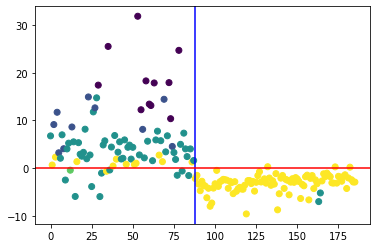

In [40]:
#Freq Lower Half
fvec = stft_run_freq_range(125,2,4,250)
X = np.asarray(fvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
res = final(X_train,y_train,X,y)
misc3_lf = get_misclassified(res)

In [10]:
tmat=[]
for i in range(88):
    tmat.append(C_cmx[i])
for i in range(98):
    tmat.append(D_cmx[i])



In [11]:
#Lbeling signals of different lengths
ylen=[]
for s in tmat:
    if(len(s)>1750):
        ylen.append(4)
    elif(len(s)>1500):
        ylen.append(3)
    elif(len(s)>1250):
        ylen.append(2)
    elif(len(s)>1000):
        ylen.append(1)
    else:
        ylen.append(0)

In [12]:
#Final Testing result
def final(X_train,y_train,X,y):
    
    clf.fit(X_train, y_train)
    ht = clf.decision_function(X)
    x = range(len(y))
    fig, ax = plt.subplots()
    ax.scatter(x,ht,c = ylen)
    ax.axvline(x=88, color='b', linestyle='-')
    ax.axhline(y=0, color='r', linestyle='-')
    print(clf.score(X,y))
    return ht

In [13]:
#Training testing data based on fixed index defined signals
def create_train_test(X,index):
    X_train=[]
    X_test=[]
    y_train=[]
    y_test=[]
    index_test =[]
    index_train=index
    for i in range(len(X)):
        if i in index_train:
            X_train.append(X[i])
            y_train.append(y[i])
        else:
            X_test.append(X[i])
            y_test.append(y[i])
            index_test.append(i)
    return X_train, X_test,y_train,y_test,index_train,index_test
        

In [14]:
def add_num(ind):
    r=random.randint(0,186)
    if r not in ind:
        ind.append(r)
    else:
        add_num(ind)

In [15]:
def get_misclassified(res):
    WrongClass=[]
    for i in range(88):
        if(res[i]<0):
            WrongClass.append([i,ylen[i]])
    for i in range(88,186):
        if(res[i]>0):
            WrongClass.append([i,ylen[i]])
    return WrongClass
    
    

In [16]:
def misc_pts(misc):
    dp=[]
    for i in misc:
        dp.append(i[0])
    print(dp)

In [17]:
from sklearn.datasets import load_digits
from sklearn.linear_model import Perceptron
clf = Perceptron(tol=1e-3, random_state=0)
y= np.concatenate((np.ones(88), np.zeros(98)))
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=2)

In [18]:
import random
index=[]
for i in range(130):
    add_num(index)

In [17]:
len(index)

130

In [19]:
vec = stft_run(125,2)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(16, 251)
0.521505376344086


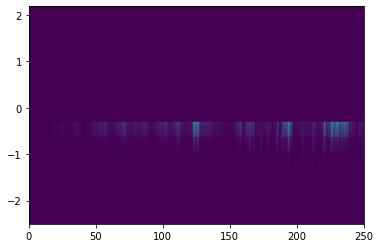

In [25]:
data = tmat[5]
L= len(data)+1
k = int((len(data) + 1)/250) # k varies from 4 to 8
N=20
B  = L/125
E =B/2#round((N*B - L)/(N-1))
nf = 2000/125
f, t, Zxx = signal.stft(tmat[5],fs= L/250, nperseg=B,noverlap= E,nfft=nf)
P =plt.pcolormesh(t, f, np.abs(Zxx)**2 ,vmax=max(np.abs(data)),shading='gouraud')
plt.show()

In [27]:
f

array([ 0.    ,  0.3125,  0.625 ,  0.9375,  1.25  ,  1.5625,  1.875 ,
        2.1875, -2.5   , -2.1875, -1.875 , -1.5625, -1.25  , -0.9375,
       -0.625 , -0.3125])

0.967741935483871


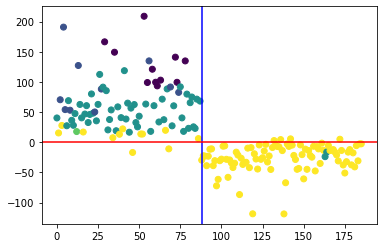

In [31]:
res = final(X_train,y_train,X,y)

In [32]:
misc1 = get_misclassified(res)

Partial Bins

In [20]:
#First half bins
vec = stft_run_half(125,2,0,125)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.5053763440860215


In [28]:
X.shape

(186, 2000)

0.956989247311828


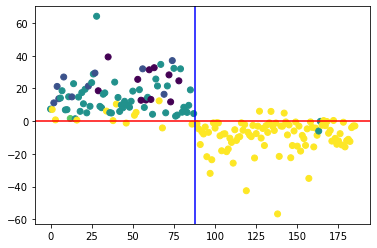

In [34]:
res = final(X_train,y_train,X,y)

In [35]:
misc2_half = get_misclassified(res)

In [21]:
#Second Half Bins
vec = stft_run_half(125,2,125,251)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.478494623655914


0.946236559139785


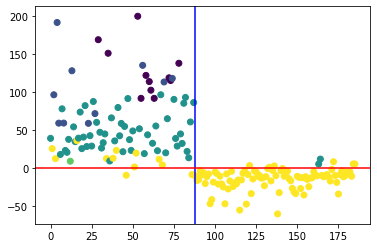

In [37]:
res = final(X_train,y_train,X,y)

In [38]:
misc2_half_r = get_misclassified(res)

In [39]:
#Q1 Bin
vec = stft_run_half(125,2,0,63)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.956989247311828


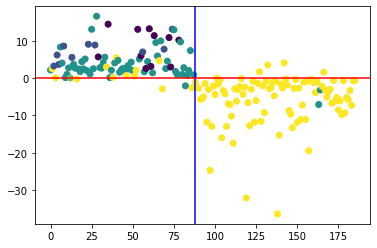

In [40]:
res = final(X_train,y_train,X,y)

In [41]:
misc2_q1 = get_misclassified(res)

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.9408602150537635


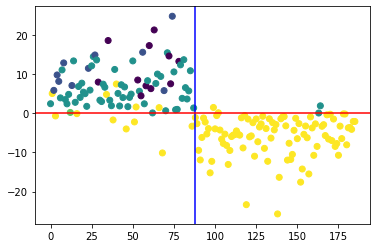

In [42]:
#Q2 Bin
vec = stft_run_half(125,2,63,125)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
res = final(X_train,y_train,X,y)
misc2_q2 = get_misclassified(res)

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.9623655913978495


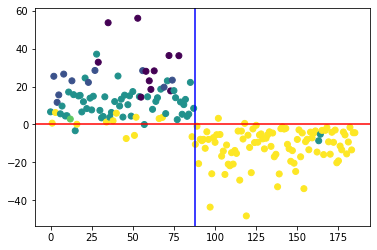

In [43]:
#Q3 Bin
vec = stft_run_half(125,2,125,188)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
res = final(X_train,y_train,X,y)
misc2_q3 = get_misclassified(res)

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.956989247311828


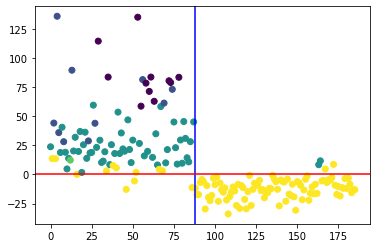

In [44]:
#Q4 Bin
vec = stft_run_half(125,2,188,251)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
res = final(X_train,y_train,X,y)
misc2_q4 = get_misclassified(res)

Partial Frequencies

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(16, 251)
0.5483870967741935
0.978494623655914


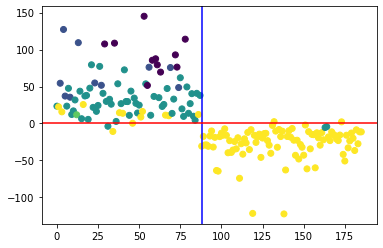

In [22]:
#Freq Lower Half
lfvec,hfvec = stft_run_freq(125,2,8)
X = np.asarray(lfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc3_lf = get_misclassified(res)

0.6720430107526881
0.9247311827956989


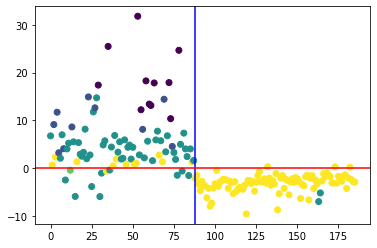

In [23]:
#Frequency Higher Half
X = np.asarray(hfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc3_hf = get_misclassified(res)

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(40, 64)
0.5376344086021505
0.978494623655914


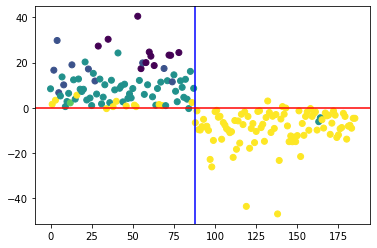

In [24]:
#Freq Div 33/40
lfvec,hfvec = stft_run_freq(50,5,33)
X = np.asarray(lfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc3_50_5_l33 = get_misclassified(res)

0.3225806451612903
0.8440860215053764


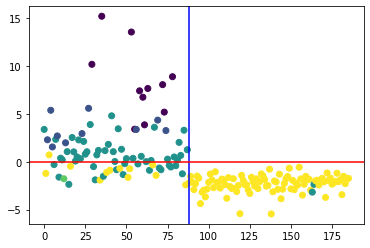

In [25]:
#Freq Div 33-40
X = np.asarray(hfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc3_50_5_h33 = get_misclassified(res)

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(40, 64)
0.5376344086021505
0.978494623655914


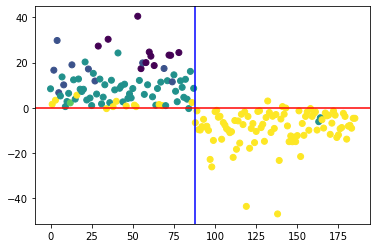

In [42]:
#Freq Div 20/40
lfvec,hfvec = stft_run_freq(50,5,20)
X = np.asarray(lfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc3_50_5_l20 = get_misclassified(res)

0.6774193548387096
0.8440860215053764


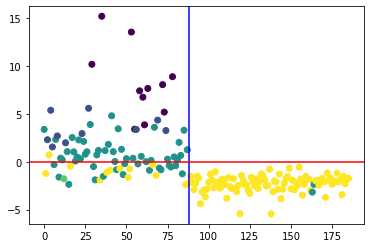

In [43]:
#Freq Div 20-40
X = np.asarray(hfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc3_50_5_h20 = get_misclassified(res)

In [51]:
print(y[88:])
print(y_km[88:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(40, 64)
0.46236559139784944
0.978494623655914


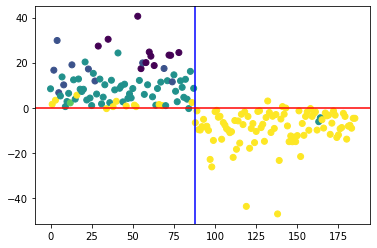

In [28]:
#Freq Div 35/40
lfvec,hfvec = stft_run_freq(50,5,35)
X = np.asarray(lfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc3_50_5_l35 = get_misclassified(res)

0.3387096774193548
0.8440860215053764


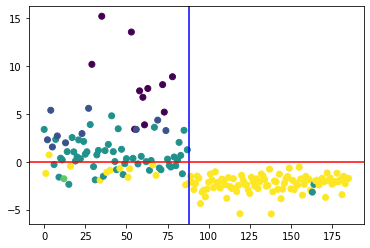

In [29]:
#Freq Div 35-40
X = np.asarray(hfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc3_50_5_h35 = get_misclassified(res)

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(40, 64)
0.5376344086021505
0.978494623655914


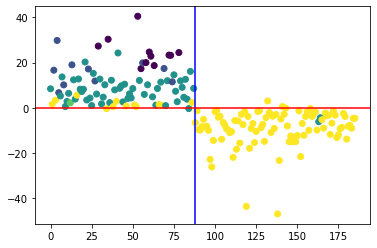

In [30]:
#Freq Div 10/40
lfvec,hfvec = stft_run_freq(50,5,10)
X = np.asarray(lfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc3_50_5_l10 = get_misclassified(res)

0.3333333333333333
0.8440860215053764


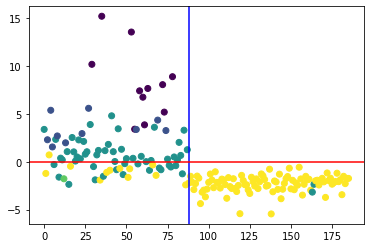

In [31]:
#Freq Div 10-40
X = np.asarray(hfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc3_50_5_h10 = get_misclassified(res)

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(16, 251)
0.553763440860215
0.9032258064516129


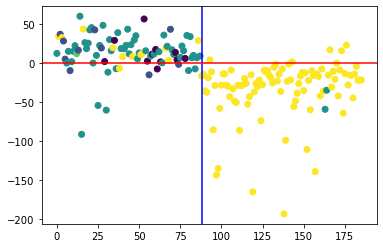

In [32]:
#Freq Div Zero
lfvec,hfvec = stft_run_freq(125,2,1)
X = np.asarray(lfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc3_125_2_z = get_misclassified(res)

0.3279569892473118
0.8978494623655914


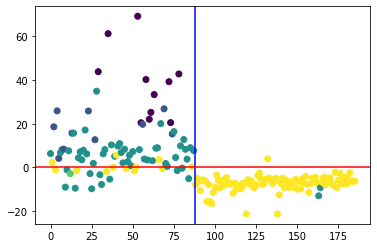

In [33]:
#Freq Div Non Zero
X = np.asarray(hfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc3_125_2_nz = get_misclassified(res)

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(40, 64)
0.7419354838709677


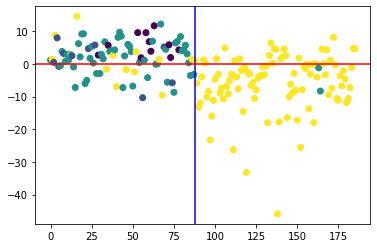

In [88]:
#Freq Div Zero
lfvec,hfvec = stft_run_freq(50,5,1)
X = np.asarray(lfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
res = final(X_train,y_train,X,y)
misc3_50_5_z = get_misclassified(res)

0.9408602150537635


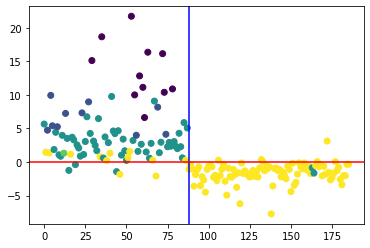

In [89]:
#Freq Div Non Zero
X = np.asarray(hfvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
res = final(X_train,y_train,X,y)
misc3_50_5_nz = get_misclassified(res)

In [84]:
print('Full')
misc_pts(misc1)
print('Half Bins')
misc_pts(misc2_half)
misc_pts(misc2_half_r)
print('Quarter Bins')
misc_pts(misc2_q1)
misc_pts(misc2_q2)
misc_pts(misc2_q3)
misc_pts(misc2_q4)

print('Frequecies (125,2)')
misc_pts(misc3_lf)
misc_pts(misc3_hf)

print('Frequencies (50,5)')
print('10/40')
misc_pts(misc3_50_5_l10)
misc_pts(misc3_50_5_h10)
print('20/40')
misc_pts(misc3_50_5_l20)
misc_pts(misc3_50_5_h20)
print('33/40')
misc_pts(misc3_50_5_l33)
misc_pts(misc3_50_5_h33)
print('35/40')
misc_pts(misc3_50_5_l35)
misc_pts(misc3_50_5_h35)

Full
[46, 68, 132, 136, 142, 172]
Half Bins
[46, 68, 86, 127, 134, 142, 166, 172]
[46, 86, 121, 133, 136, 163, 164, 172, 184, 185]
Quarter Bins
[16, 68, 82, 86, 127, 132, 142, 166]
[3, 16, 38, 46, 51, 68, 86, 99, 102, 163, 164]
[15, 46, 51, 57, 86, 102, 118]
[16, 46, 51, 86, 163, 164, 167, 172]
Frequecies (125,2)
[44, 46, 68, 127, 133, 142, 172]
[15, 16, 19, 44, 46, 57, 68, 90, 120, 132, 136, 172]
Frequencies (50,5)
10/40
[44, 46, 68, 86, 133, 172]
[15, 19, 22, 40, 44, 46, 51, 68, 86, 132, 166, 172, 184, 185]
20/40
[44, 46, 68, 86, 133, 172]
[15, 19, 22, 40, 44, 46, 51, 68, 86, 132, 166, 172, 184, 185]
33/40
[44, 46, 68, 86, 133, 172]
[15, 19, 22, 40, 44, 46, 51, 68, 86, 132, 166, 172, 184, 185]
35/40
[44, 46, 68, 86, 133, 172]
[15, 19, 22, 40, 44, 46, 51, 68, 86, 132, 166, 172, 184, 185]


C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(40, 64)
0.956989247311828
[[34, 4], [51, 4], [86, 4], [92, 4], [93, 4], [112, 4], [126, 4], [164, 2]]


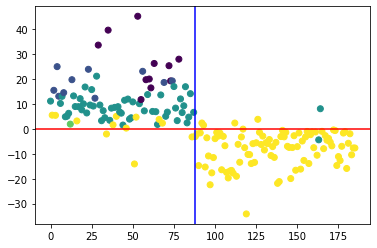

In [63]:
vec = stft_run(50,5)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
res = final(X_train,y_train,X,y)
print(get_misclassified(res))

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.956989247311828
[[34, 4], [51, 4], [86, 4], [92, 4], [93, 4], [112, 4], [126, 4], [164, 2]]


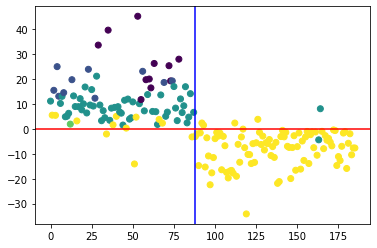

In [85]:
vec = stft_run_half(50,5,0,64)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
res = final(X_train,y_train,X,y)
print(get_misclassified(res))

In [98]:
#Stamdard STFT Run. Returns Full Flattened Vector
def stft_run_collapse(n_ratio,o_ratio):
    C_spec = []
    vec= []
    for j in range(len(tmat)):
        data = tmat[j]
        L= len(data)+1
        k = int((len(data) + 1)/250) # k varies from 4 to 8
        N=20
        B  = L/n_ratio
        E =B/o_ratio#round((N*B - L)/(N-1))
        nf = 2000/n_ratio
        f, t, Zxx = signal.stft(tmat[j],fs= L/250, nperseg=B,noverlap= E,nfft=nf)
        
        tot = np.abs(Zxx)**2
        
        
        C_spec.append(np.abs(Zxx)**2)
    
    vec = []
    for i in range(len(C_spec)):
        m=[]
        for j in C_spec[i]:
            m.append(np.mean(j))
        vec.append(m)
    

    
    

    return vec

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.8709677419354839
[[1, 4], [16, 4], [40, 4], [46, 4], [51, 4], [88, 4], [89, 4], [93, 4], [112, 4], [116, 4], [123, 4], [125, 4], [140, 4], [141, 4], [142, 4], [149, 4], [155, 4], [156, 4], [158, 4], [163, 2], [164, 2], [168, 4], [172, 4], [178, 4]]


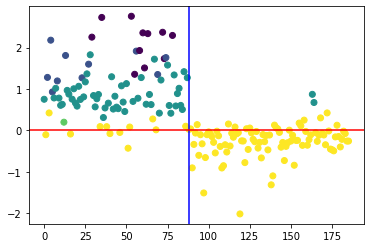

In [107]:
vec = stft_run_collapse(25,5)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
res = final(X_train,y_train,X,y)
print(get_misclassified(res))